In [1]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## MNIST

In [2]:
dl_train = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/mnist', train=True, download=False))

dl_test  = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/mnist', train=False, download=False))

0it [00:00, ?it/s]

100%|█████████▉| 9912320/9912422 [07:27<00:00, 51740.28it/s] 

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



0it [00:00, ?it/s]


 57%|█████▋    | 16384/28881 [00:11<00:01, 6887.59it/s]

0it [00:00, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw


9920512it [07:40, 51740.28it/s]                             
32768it [00:22, 6887.59it/s]                           

  0%|          | 0/1648877 [00:13<?, ?it/s]

  1%|          | 16384/1648877 [00:25<20:01, 1358.31it/s]

  1%|▏         | 24576/1648877 [00:26<14:27, 1872.19it/s]

  2%|▏         | 32768/1648877 [00:30<13:57, 1929.44it/s]

  2%|▏         | 40960/1648877 [00:31<11:18, 2371.18it/s]

  3%|▎         | 49152/1648877 [00:32<08:48, 3026.17it/s]

  3%|▎         | 57344/1648877 [00:33<06:38, 3995.29it/s]

  4%|▍         | 65536/1648877 [00:33<04:59, 5281.22it/s]

  4%|▍         | 73728/1648877 [00:33<03:48, 6879.03it/s]

  5%|▍         | 81920/1648877 [00:34<02:58, 8793.53it/s]

  6%|▌         | 98304/1648877 [00:34<02:08, 12040.79it/s]

  6%|▋         | 106496/1648877 [00:34<01:36, 15987.11it/s]

  7%|▋         | 122880/1648877 [00:34<01:14, 20518.46it/s]

  9%|▉         | 147456/1648877 [00:35<00:55, 26926.68it/s]

  9%|▉         | 155648/1648877 [00:35<00:55, 26868.15it/s]

 1

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




1654784it [01:01, 156485.55it/s]


  0%|          | 0/4542 [00:11<?, ?it/s]


8192it [00:12, 5581.46it/s]             

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!


In [3]:
train_data   = dl_train.dataset.data.to(dtype=torch.float32)
train_labels = dl_train.dataset.targets

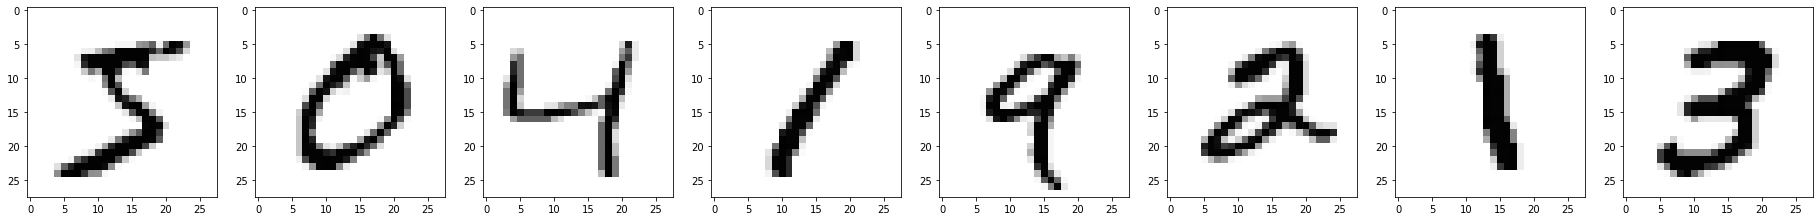

In [4]:
fig_mnist, ax = plt.subplots(1,8, figsize=(8*4,4))
for i in range(8):
    ax[i].imshow(train_data[i].numpy(), cmap='Greys');

In [5]:
train_labels[0:8]

tensor([5, 0, 4, 1, 9, 2, 1, 3])

## Standarisation/Normalisation

In [6]:
train_dataset = torch.utils.data.TensorDataset( 
    (train_data/128.0-1.0).view(-1,28*28), 
    train_labels)

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=100, 
                                           shuffle=True)

In [8]:
test_data   = dl_test.dataset.data.to(dtype=torch.float32)
test_labels = dl_test.dataset.targets
test_dataset = torch.utils.data.TensorDataset(
    (test_data/128.8-1.0).view(-1,28*28), test_labels)

## Batch normalisation

$$\hat{x}_{ij} = \frac{x_{ij}-\mu_j}{\sigma_j},
\quad \mu_j=\frac{1}{N_{batch}}\sum_{i\in batch} x_{ij},
\quad \sigma_j = \sqrt{\frac{1}{N_{batch}}\sum_{i\in batch}(x_{ij}-\mu_j)^2}$$

$$y_{ik}=\gamma_j \hat{x}_{ij}+\beta_j $$

In [9]:
model = torch.nn.Sequential(
    nn.Linear(28*28,1200), nn.ReLU(),
    nn.BatchNorm1d(1200),
    nn.Linear(1200,1200), nn.ReLU(),
    nn.BatchNorm1d(1200),
    nn.Linear(1200,1200), nn.ReLU(),
    nn.BatchNorm1d(1200),
    nn.Linear(1200,10),
    nn.BatchNorm1d(10)
)

In [10]:
optim = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.6)

In [11]:
loss_f = nn.CrossEntropyLoss()

In [12]:
errors = []
batches = 0
epochs = 0

In [13]:
%%time
model.train()
for e in range(10):
    for d in train_loader:        
        optim.zero_grad()
        features, labels = d
        pred = model(features)
        loss = loss_f(pred, labels)
        errors.append(loss.item())
        loss.backward()
        optim.step()
        batches += 1
    epochs += 1   
print(loss)        




8192it [00:30, 5581.46it/s]

tensor(0.0096, grad_fn=<NllLossBackward>)
CPU times: user 25min 35s, sys: 9min 16s, total: 34min 51s
Wall time: 17min 39s


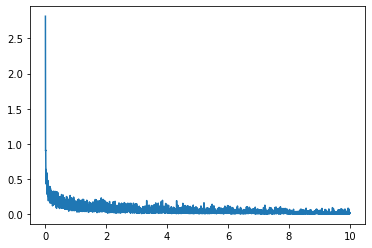

In [14]:
plt.plot(np.linspace(0,epochs, batches),errors)

In [15]:
model.eval()
with torch.no_grad():
    pred = torch.softmax(model(train_dataset[:][0]),1)
    ac = torch.sum(torch.argmax(pred,1)==train_labels).to(dtype=torch.float32)/len(train_dataset)
ac  

tensor(0.9986)

In [16]:
model.eval()
with torch.no_grad():
    pred = torch.softmax(model(test_dataset[:][0]),1)
    ac = torch.sum(torch.argmax(pred,1)==test_labels).to(dtype=torch.float32)/len(test_dataset)
ac    

tensor(0.9857)